# Instalación de paquetes, funciones y descarga de los conjuntos de datos

In [42]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Se cargan en pandas los 4 conjuntos de datos que se van a utilizar en forma de diccionario
lista_letras = ['A','B','C','D']
datos = {}

for i in lista_letras:
    datos['data{}'.format(i)] = pd.read_csv('input/MuonCert_Labeled_UL2018{}_Reduced.csv'.format(i))

# Preparación de los datos

In [43]:
#Limpieza de datos: Se eliminan lumisections con menos de 300 eventos
for j in lista_letras:
    datos['data{}'.format(j)] = datos['data{}'.format(j)][datos['data{}'.format(j)]['entries']>=300]

In [44]:
#Se ordenan los datos de forma creciente según el número de run y de lumisection
for j in lista_letras:
    datos['data{}'.format(j)] = datos['data{}'.format(j)].sort_values(by = ['fromrun', 'fromlumi'])

In [45]:
#Se crean dataframes que contienen los datos de cada propiedad para cada conjunto una vez que se ha realizado la limpieza. Se guardan en el diccionario conjuntos
propiedades = ['pt','eta','chi2OverDf','phi']
conjuntos = {}
for i in lista_letras:
    for j in propiedades:
        conjuntos['{}{}'.format(j,i)] = datos['data{}'.format(i)][datos['data{}'.format(i)]['hname']=='GlbMuon_Glb_{}'.format(j)]

In [46]:
#Se crea un diccionario renombrando las runs para que sean consecutivas.
rename = {}
runs = np.sort(pd.concat((conjuntos['ptA']['fromrun'], conjuntos['ptB']['fromrun'], conjuntos['ptC']['fromrun'], conjuntos['ptD']['fromrun'])).unique())
k = 1
for i in runs:
    rename[i] = k
    k += 1

In [47]:
#Se añade una columna con el número nuevo de run y de lumisection
pd.options.mode.chained_assignment = None
for i in lista_letras:
    for j in propiedades:
        long = len(conjuntos['{}{}'.format(j,i)])
        conjuntos['{}{}'.format(j,i)]['new_run'] = conjuntos['{}{}'.format(j,i)]['fromrun'].map(rename)
        conjuntos['{}{}'.format(j,i)]['new_lumi'] = np.linspace(0, long-1, long)

# Número de lumisections en cada run

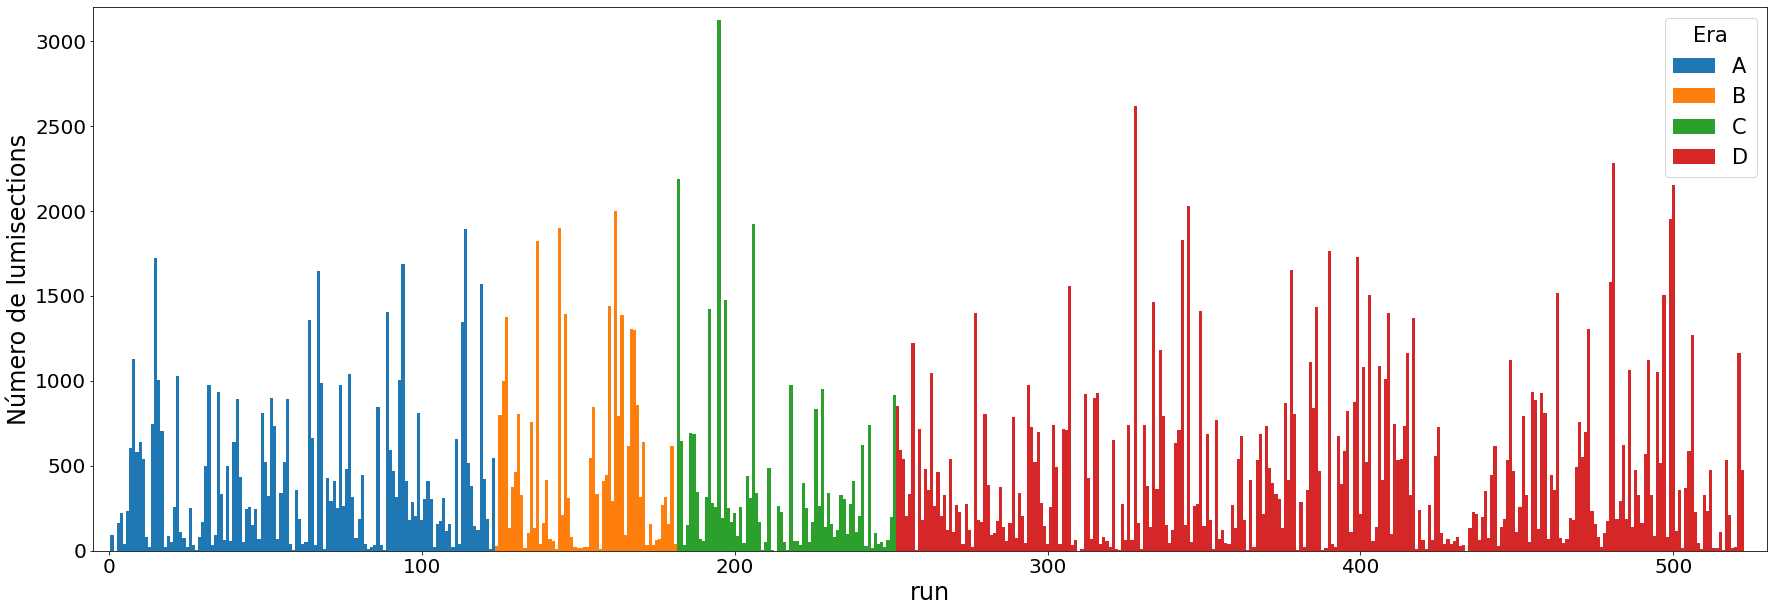

In [48]:
#Representación del número de lumisections en cada run, todo ello separado por eras
plt.figure(figsize=(30,10))
for i in lista_letras:
    plt.hist(conjuntos['pt{}'.format(i)]['new_run'], bins=range(min(conjuntos['pt{}'.format(i)]['new_run']),max(conjuntos['pt{}'.format(i)]['new_run'])+2), align = 'left')
plt.ylim((0,3200))
plt.xlim((-5,530))
plt.xlabel("run", fontdict = {'size':24})
plt.ylabel("Número de lumisections", fontdict = {'size':24})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(labels = lista_letras, fontsize = 21, title='Era', title_fontsize=21)
plt.savefig('graficas/runs.pdf')

# Proporción de datos etiquetados como malos

In [49]:
suma_malos = 0
len_total = 0
for i in lista_letras:
    print('Proporción de datos malos en la era {}:'.format(i), np.sum(conjuntos['pt{}'.format(i)]['labels']==False)/len(conjuntos['pt{}'.format(i)])*100)
    suma_malos = suma_malos+np.sum(conjuntos['pt{}'.format(i)]['labels']==False)
    len_total = len_total+len(conjuntos['pt{}'.format(i)])
print('Proporción de datos malos total:', suma_malos/len_total*100)

Proporción de datos malos en la era A: 0.48183839881393625
Proporción de datos malos en la era B: 0.7558098467189377
Proporción de datos malos en la era C: 1.4807317438896386
Proporción de datos malos en la era D: 0.4658987964281092
Proporción de datos malos total: 0.622922865445181


# Histogramas ideales

In [50]:
#Se separan los datos considerados como buenos para cada una de las propiedades estudiadas en el dataset A.
conjuntos_buenos = {}
for i in propiedades:
    conjuntos_buenos['{}_true'.format(i)] = conjuntos['{}A'.format(i)][conjuntos['{}A'.format(i)]['labels']==True]

In [51]:
#Extraemos los datos del eje y (número de eventos). Para ello se suman los correspondientes a cada lumisection.
y = {}
for i in propiedades:
    y['y_{}'.format(i)] = np.array(eval(conjuntos_buenos['{}_true'.format(i)]['histo'].values[0])).astype(int)

for j in range(1,conjuntos_buenos['pt_true'].shape[0]):
    for i in propiedades:
        y['y_{}'.format(i)] = y['y_{}'.format(i)] + np.array(eval(conjuntos_buenos['{}_true'.format(i)]['histo'].values[j])).astype(int)

In [52]:
#Creamos los datos para el eje x
x = {}
for i in propiedades:
    x['x_{}'.format(i)] = np.linspace(conjuntos_buenos['{}_true'.format(i)]["Xmin"].tolist()[0], conjuntos_buenos['{}_true'.format(i)]["Xmax"].tolist()[0], conjuntos_buenos['{}_true'.format(i)]["Xbins"].tolist()[0]+1)
    x['x_{}'.format(i)] = x['x_{}'.format(i)][0:-1]

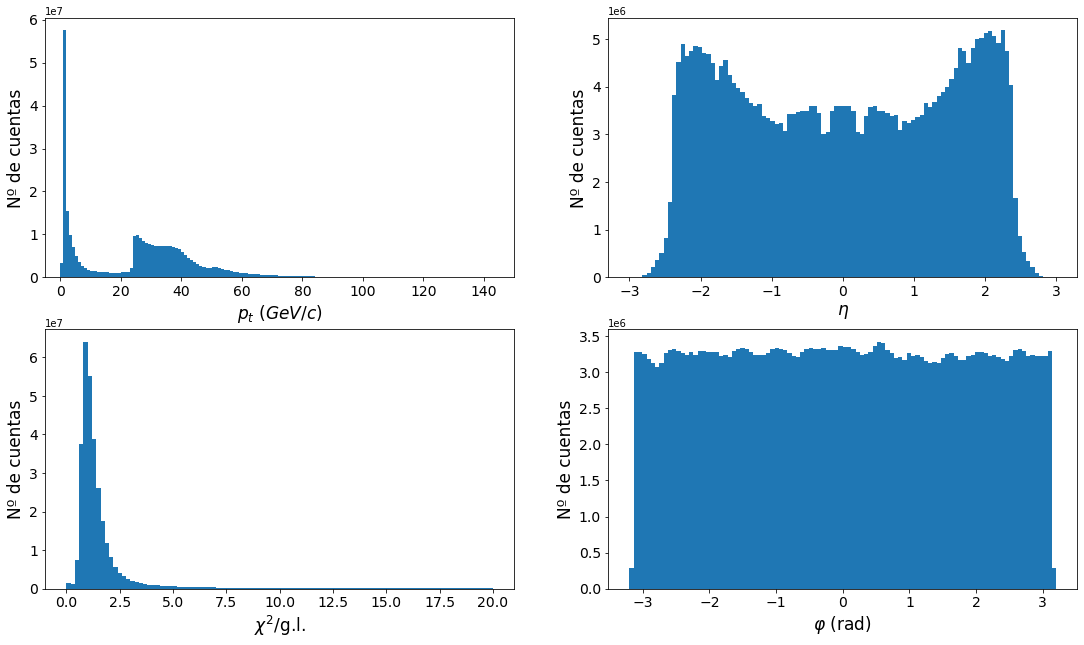

In [53]:
#Se representan los histogramas con todos los datos etiquetados como buenos en la era A
fig, axs = plt.subplots(2,2)
axs = axs.flatten()
for i in range(0,4):
    prop = propiedades[i]
    axs[i].bar(x['x_{}'.format(prop)], y['y_{}'.format(prop)].tolist(), align='edge', width=(x['x_{}'.format(prop)][1]-x['x_{}'.format(prop)][0]))
    axs[i].set_ylabel('Nº de cuentas', fontsize=17)
    axs[i].tick_params(axis='both', labelsize=14)
    
axs[0].set_xlabel(r'$p_t \, \, (GeV/c)$', fontsize=17)
axs[1].set_xlabel(r'$\eta$', fontsize=17)
axs[2].set_xlabel(r'$\chi^2$/g.l.', fontsize=17)
axs[3].set_xlabel(r'$\varphi$ (rad)', fontsize=17)
axs[0].set_xlim(-5,150)
fig.set_size_inches(18.5, 10.5)
fig.savefig('graficas/DatosTotalesBuenos.pdf', dpi=100)

# Preparación datos para PCA

In [54]:
%run funciones.ipynb

In [55]:
#Se crean las matrices sobre las que se aplica PCA
bins = {'binspt':500, 'binseta':100, 'binschi2OverDf':100, 'binsphi':100}
V = {}
for i in lista_letras:   #lista_letras
    for j in propiedades:  #propiedades
        n = np.shape(conjuntos['{}{}'.format(j,i)])[0]
        V['V{}{}'.format(j,i)] = np.zeros((n, bins['bins{}'.format(j)]))
        for k in range(0,n):
            V['V{}{}'.format(j,i)][[k]] = str_array(conjuntos['{}{}'.format(j,i)]['histo'],k) 

# Comparación entre histogramas con diferente número de componentes principales

In [56]:
#Obtención de los histogramas reconstruidos para tres números distintos de componentes principales
recon1,_ = evaluation(V['VptB'], training(conjuntos, V, 'pt', ['C'], 1, 0))
recon20,_ = evaluation(V['VptB'], training(conjuntos, V, 'pt', ['C'], 20, 0))
recon50,_ = evaluation(V['VptB'], training(conjuntos, V, 'pt', ['C'], 50, 0))

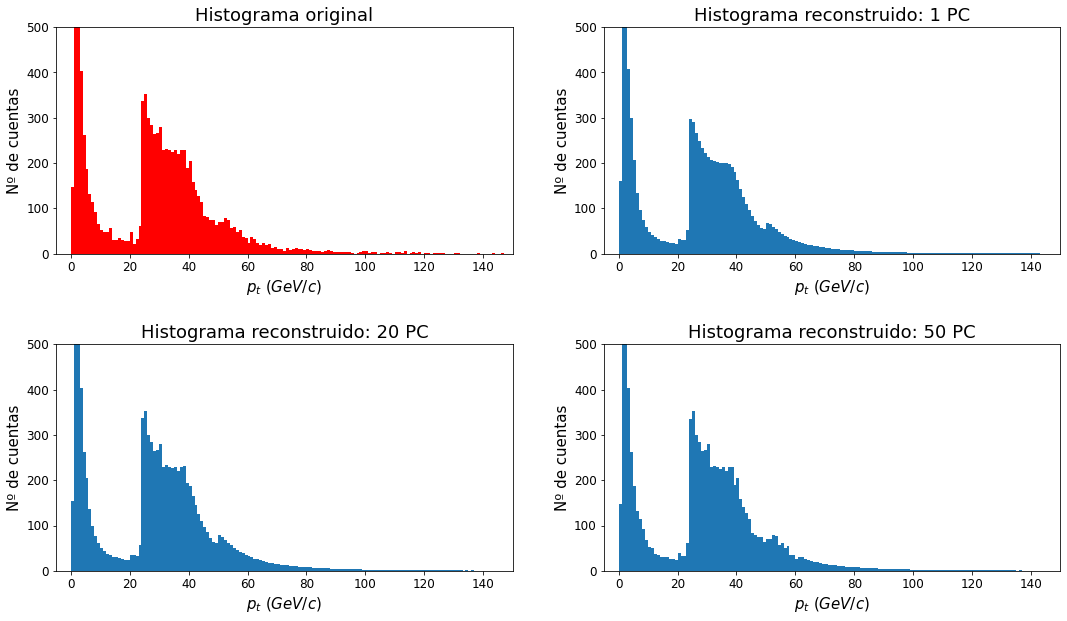

In [57]:
#Comparación entre un histograma original y un histograma reconstruido para distintos números de componentes principales
fig, axs = plt.subplots(2,2)
fig.set_size_inches(18, 10)
axs = axs.flatten()
axs[0].bar(x['x_pt'], V['VptB'][10], align='edge', width=(x['x_pt'][1]-x['x_pt'][0]), color='red')
axs[1].bar(x['x_pt'], recon1[10], align='edge', width=(x['x_pt'][1]-x['x_pt'][0]))
axs[2].bar(x['x_pt'], recon20[10], align='edge', width=(x['x_pt'][1]-x['x_pt'][0]))
axs[3].bar(x['x_pt'], recon50[10], align='edge', width=(x['x_pt'][1]-x['x_pt'][0]))
for i in range(0,4):
    axs[i].set_ylim(0,500)
    axs[i].set_xlim(-5,150)
    axs[i].set_xlabel(r'$p_t \, \, (GeV/c)$', fontsize=15)
    axs[i].set_ylabel('Nº de cuentas', fontsize=15)
    axs[i].tick_params(axis='both', labelsize=12)
axs[0].set_title('Histograma original', fontsize=18)
axs[1].set_title('Histograma reconstruido: 1 PC', fontsize=18)
axs[2].set_title('Histograma reconstruido: 20 PC', fontsize=18)
axs[3].set_title('Histograma reconstruido: 50 PC', fontsize=18)
plt.subplots_adjust(hspace = 0.4)
fig.savefig('graficas/ReconNumeroPC.pdf', dpi=100)

# Ejemplo de aplicación a ptB

In [58]:
#Prueba de aplicación de PCA a ptB. Entrenamiento en la era C. 
recon, mse = evaluation(V['VptB'], training(conjuntos, V, 'pt', ['C'], 3, 0))

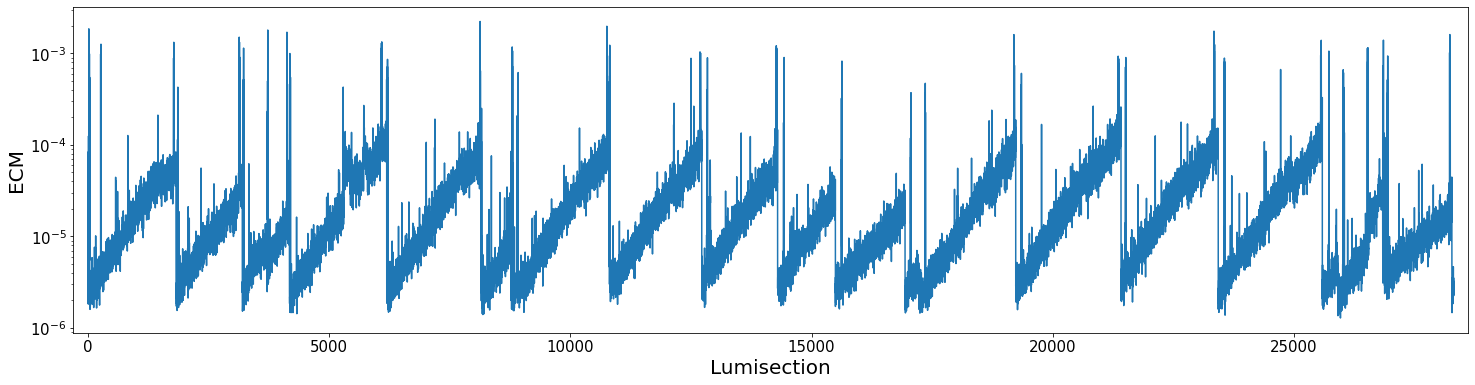

In [59]:
#Representación del MSE
plt.figure(figsize=(25,6))
plt.plot(mse)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-300, len(mse)+300))
plt.savefig('graficas/ejemploECM.pdf')

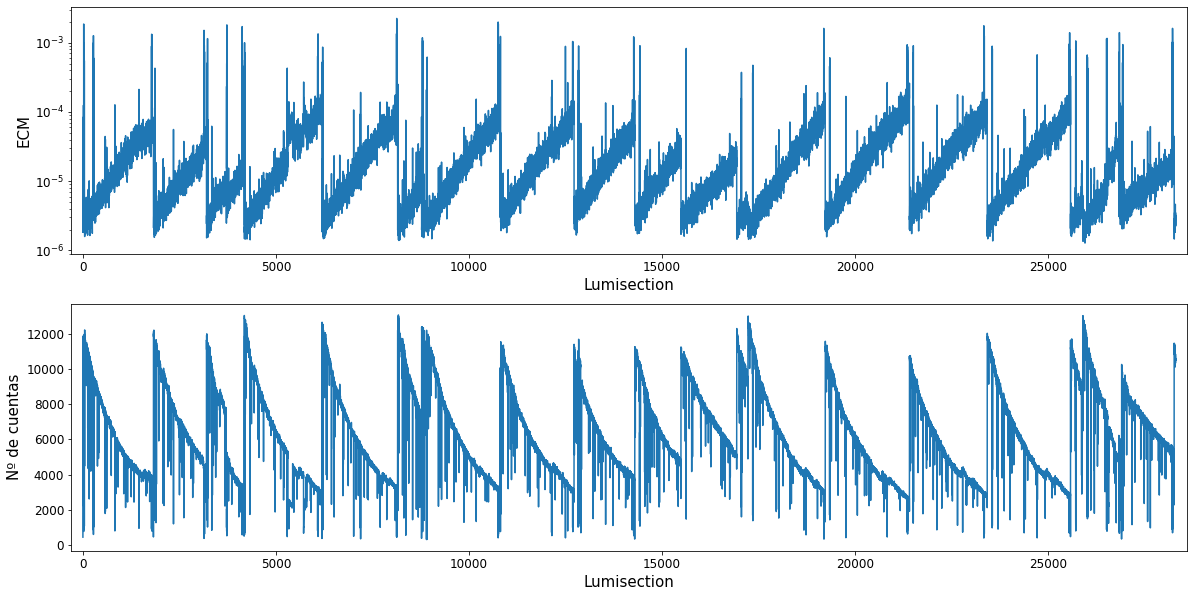

In [60]:
#Relación del MSE con la luminosidad instantánea a través del número de eventos en cada lumisection
fig, axs = plt.subplots(2,1)
ax0, ax1 = axs.flatten()
ax0.plot(mse)
ax0.set_yscale('log')
ax0.set_xlabel('Lumisection', fontsize=15)
ax0.set_ylabel('ECM', fontsize=15)
ax0.tick_params(axis='both', labelsize=12)
ax0.set_xlim((-300, len(mse)+300))
ax1.plot(np.sum(V['VptB'], axis=1))
ax1.set_xlabel('Lumisection', fontsize=15)
ax1.set_ylabel('Nº de cuentas', fontsize=15)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlim((-300, len(mse)+300))
fig.set_size_inches(20,10)
fig.savefig('graficas/MSEfills.pdf', dpi=100)

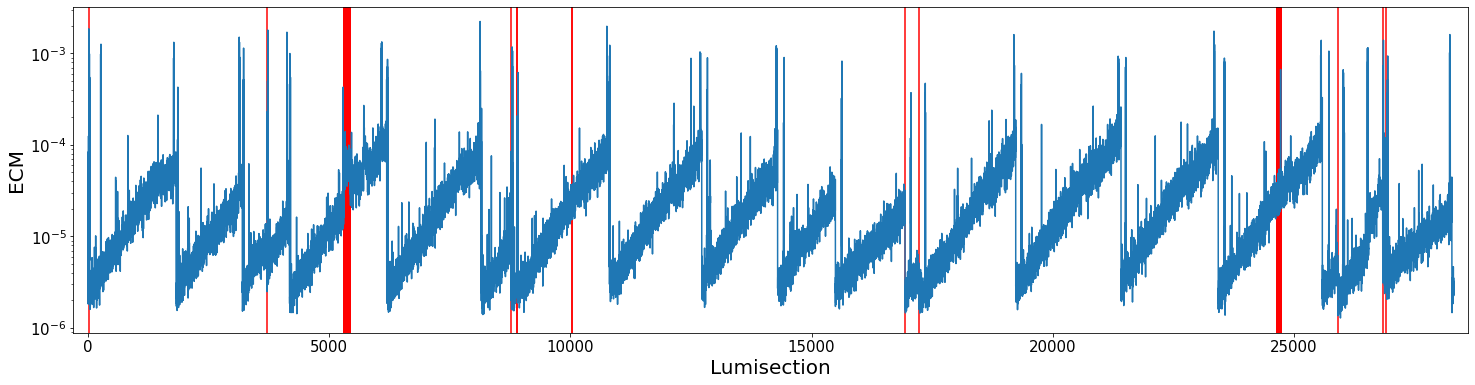

In [61]:
#Representación del MSE y los datos etiquetados como malos por los expertos (en rojo)
plt.figure(figsize=(25,6))

falsos = conjuntos['ptB'][conjuntos['ptB']['labels']==False]['new_lumi']
for coord in falsos:
    plt.axvline(x = coord, color='red')

plt.plot(mse)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-300, len(mse)+300))
plt.savefig('graficas/ECMfalsos.pdf')

# Cálculo de regiones anómalas

In [62]:
#Suavizado de los datos mediante media móvil y mediana móvil
mse_df = pd.DataFrame(mse)
smoothed_mse_mean = mse_df.rolling(window = 100, center=True).mean()
smoothed_mse_median = mse_df.rolling(window = 100, center=True).apply(np.median)

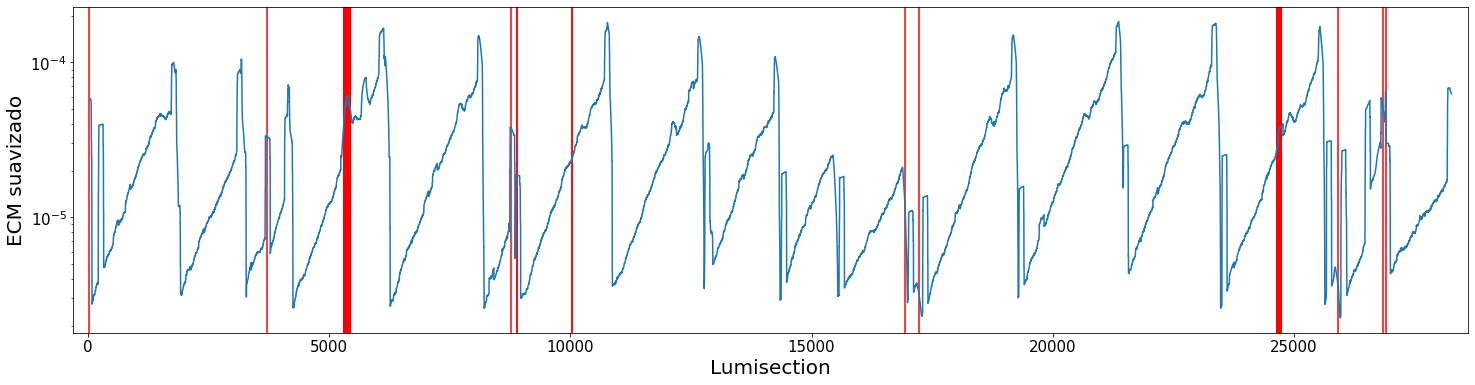

In [63]:
#Datos suavizados con media móvil y etiquetas de datos malos de los expertos
plt.figure(figsize=(25,6))
for coord in falsos:
    plt.axvline(x = coord, color='red')
plt.plot(smoothed_mse_mean)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM suavizado', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-300, len(smoothed_mse_mean)+300))
plt.savefig('graficas/ECMsuavizado.pdf')

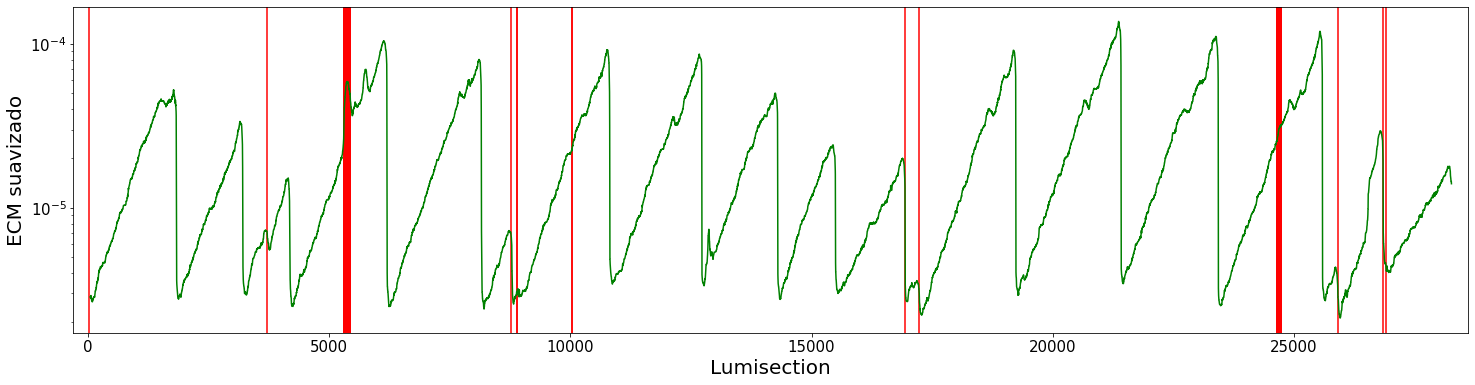

In [64]:
#Datos suavizados con mediana móvil y etiquetas de datos malos de los expertos
plt.figure(figsize=(25,6))
for coord in falsos:
    plt.axvline(x = coord, color='red')
plt.plot(smoothed_mse_median, color='green')
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM suavizado', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-300,len(smoothed_mse_median)+300))
plt.savefig('graficas/ECMsuavizado2.pdf')

In [65]:
#Determinamos las anomalías para los datos con los que estamos trabajando usando suavizado con mediana móvil
from scipy.signal import find_peaks
descartes, maximos = anomalias(smoothed_mse_median[0], 25)

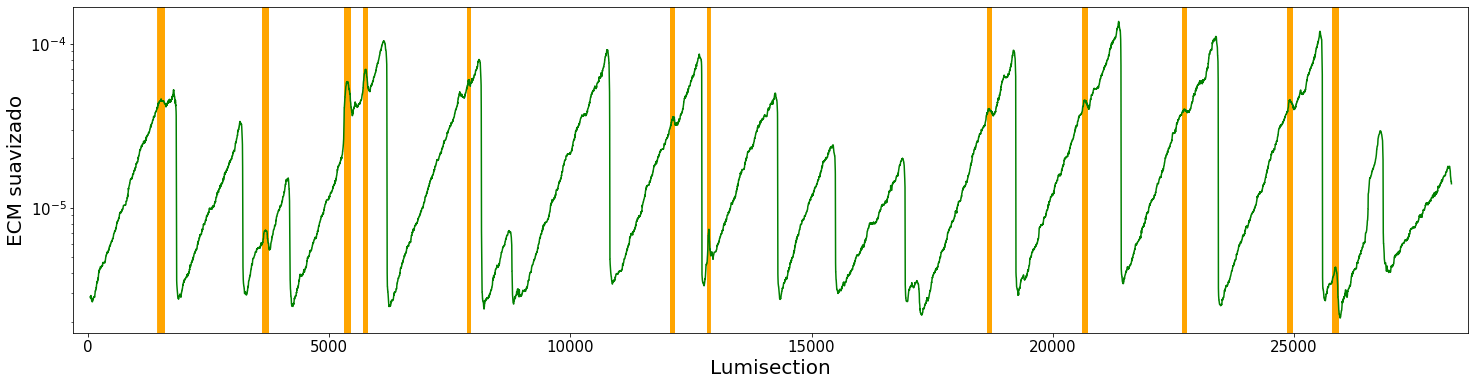

In [66]:
#Representamos los datos descartados sobre los suavizados
plt.figure(figsize=(25,6))

for i in range(0,np.shape(descartes)[1]):
    for j in range(descartes[0,i]-descartes[1,i], descartes[0,i]+descartes[1,i]):
        plt.axvline(x = j, color='orange', zorder=0)

plt.plot(smoothed_mse_median, color='green')
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM suavizado', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-300,len(smoothed_mse_median)+300))
plt.savefig('graficas/picosSuavizado.pdf', dpi=100)

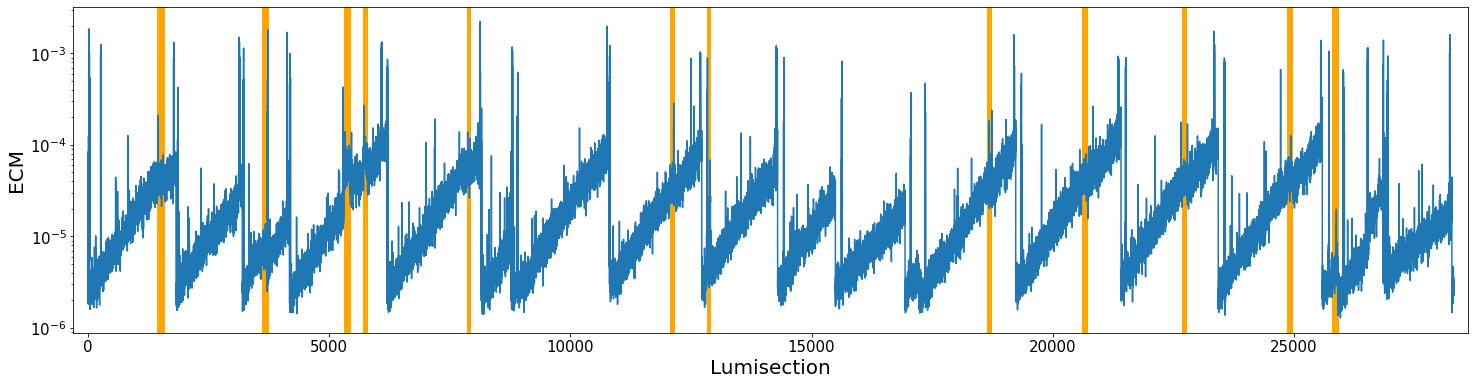

In [67]:
#Representamos datos descartados respecto a los originales
plt.figure(figsize=(25,6))
for i in range(0,np.shape(descartes)[1]):
    for j in range(descartes[0,i]-descartes[1,i], descartes[0,i]+descartes[1,i]):
        plt.axvline(x = j, color='orange', zorder=0)
plt.plot(mse)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-300,len(mse)+300))
plt.savefig('graficas/DescartesZonas.pdf')

# Estudio del parámetro de corte

In [68]:
#Calculamos el parámetro de corte y los datos descartados aplicando dicho criterio
vmax, falsos_corte = corte(mse, smoothed_mse_median, maximos)

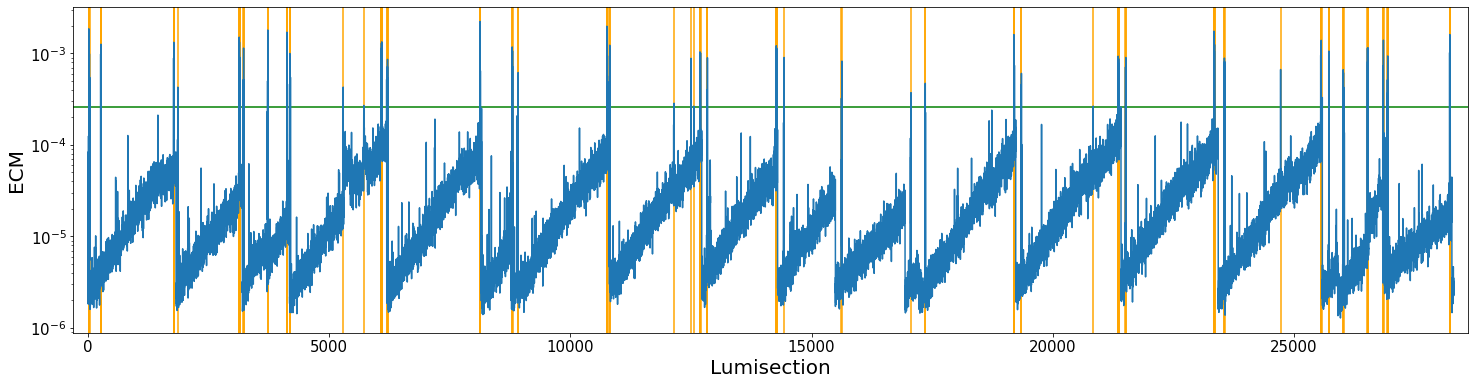

In [69]:
#Se representa el MSE, los datos descartados por el modelo (naranja) y el parámetro de corte (verde)
plt.figure(figsize=(25,6))
for j in falsos_corte:
    plt.axvline(x = j, color='orange', zorder=0)
plt.axhline(y = vmax, color='green')
plt.plot(mse)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-300,len(mse)+300))
plt.savefig('graficas/DescartesCorte.pdf')

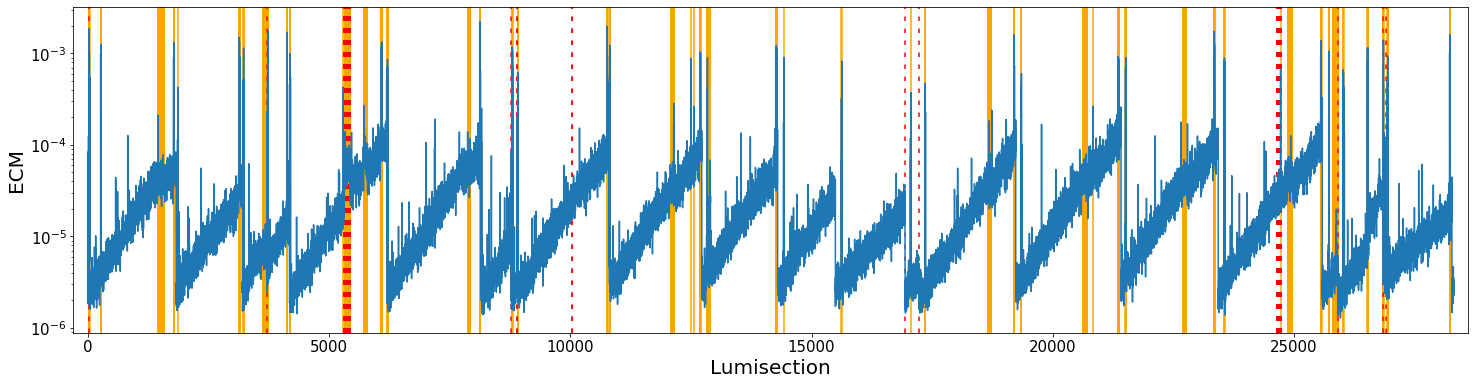

In [70]:
#Representamos datos descartados respecto a los originales juntando los correspondientes al parámetro de corte y al descarte por zonas. Se añaden los descartes de los expertos
plt.figure(figsize=(25,6))
for i in range(0,np.shape(descartes)[1]):
    for j in range(descartes[0,i]-descartes[1,i], descartes[0,i]+descartes[1,i]):
        plt.axvline(x = j, color='orange', zorder=0)
for j in falsos_corte:
    plt.axvline(x = j, color='orange', zorder=0)
for coord in falsos:
    plt.axvline(x = coord, color='red', linestyle=(0,(3,5)))
plt.plot(mse)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-300,len(mse)+300))
plt.savefig('graficas/DescartesTotal.pdf')

# Evaluación del comportamiento del modelo

In [71]:
#Se prueba el funcionamiento del modelo con entrenamiento en la era C y evaluación en la era B
entrenamiento = ['C']
evaluacion = ['B']

malos, mse = datos_malos(conjuntos, V, entrenamiento, evaluacion, 3)

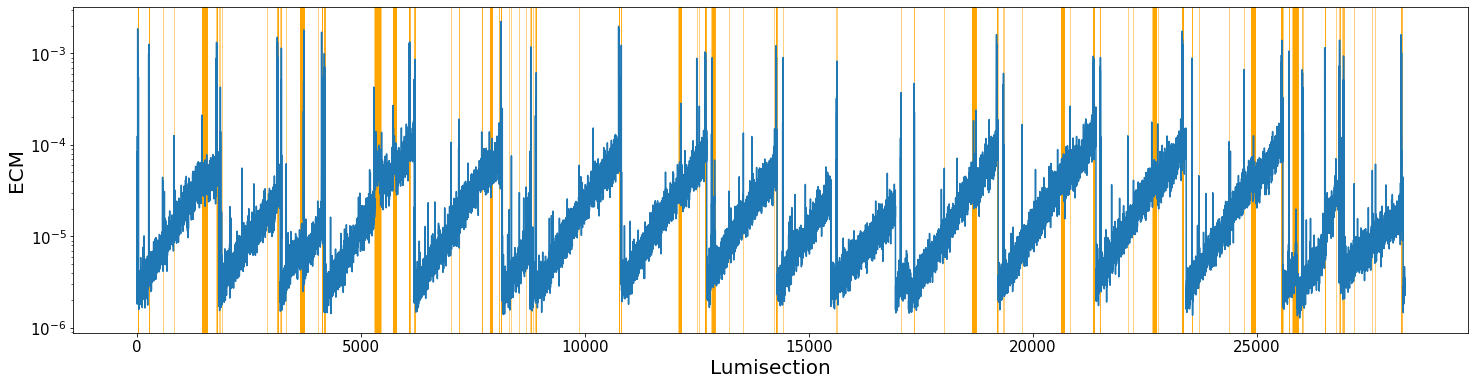

In [72]:
#Aquí el mse es el correspondiente a pt. Se pintan los datos descartados usando ambos criterios y las cuatro propiedades.
plt.figure(figsize=(25,6))
for j in malos:
    plt.axvline(x = j, color='orange', zorder=1, linewidth=0.5)
plt.plot(mse)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)

In [73]:
#Entrenamiento con A,B,D. Evaluación en C del modelo completo. Cambiando las eras de entrenamiento y evaluación se obtienen todos los resultados
entrenamiento = ['B','C','D']
evaluacion = ['A']
n = [2,1,2,3]

malos, mse = datos_malos(conjuntos, V, entrenamiento, evaluacion, n)
_,_ = resultados(conjuntos,evaluacion,malos,1)

TP: 49211   FN: 1804
FP: 171      TN: 76
PPV: 0.9965371997893969
TPR: 0.9646378516122709
TNR: 0.3076923076923077
F12: 0.989989659736947
GM: 0.5448042278194338


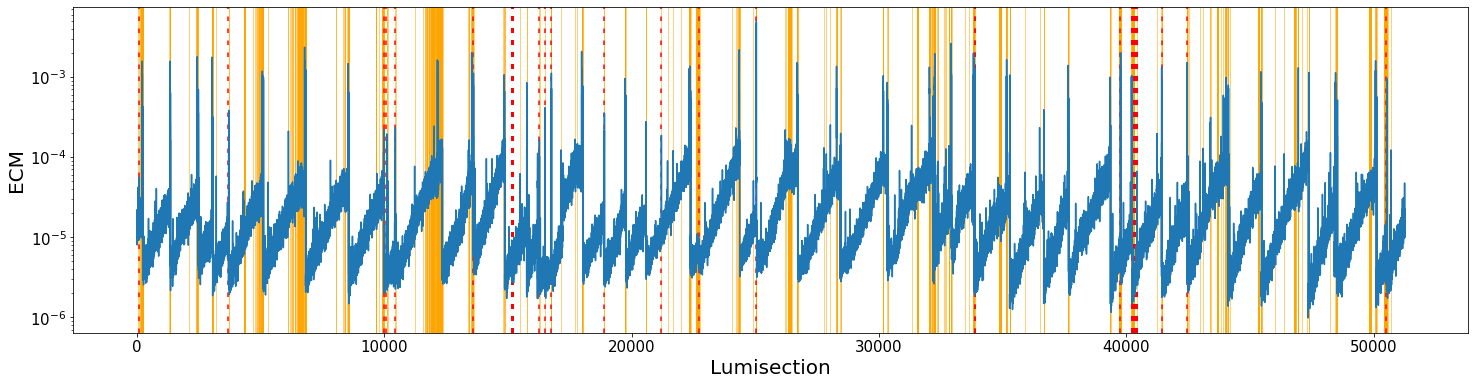

In [74]:
#Aquí el mse es el correspondiente a pt. Son los descartes del modelo completo.
plt.figure(figsize=(25,6))
falsos = conjuntos['pt{}'.format(evaluacion[0])][conjuntos['pt{}'.format(evaluacion[0])]['labels']==False]['new_lumi']
for j in malos:
    plt.axvline(x = j, color='orange', zorder=1, linewidth=0.5)
for coord in falsos:
    plt.axvline(x = coord, color='red', linestyle=(0,(3,5)))
plt.plot(mse)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.savefig('graficas/TotalD.pdf', dpi=100)

# Estimación del número óptimo de componentes principales

In [75]:
# Estimación del número de componentes principales
# from funciones import datos_malos_PC
# entrenamiento = ['C']
# evaluacion = ['B']
# F12_pt = np.zeros((1,100))[0]
# GM_pt = np.zeros((1,100))[0]
# for n in range(1,101):
#     malos, mse = datos_malos_PC(conjuntos, V, entrenamiento, evaluacion, n, 'pt')
#     F12_pt[n-1], GM_pt[n-1] = resultados(conjuntos,evaluacion,malos,0)
#     if n%10==0:
#         print(n)

In [76]:
#Esta celda permite leer un archivo en el que se incluyen los resultados de la anterior para aligerar el tiempo de ejecución del código
F12GM = pd.read_csv('input/F12GM.csv', header=None, index_col=0)
F12_eta = F12GM.iloc[0]
GM_eta = F12GM.iloc[1]
F12_phi = F12GM.iloc[2]
GM_phi = F12GM.iloc[3]
F12_pt = F12GM.iloc[4]
GM_pt = F12GM.iloc[5]
F12_chi2OverDf = F12GM.iloc[6]
GM_chi2OverDf = F12GM.iloc[7]

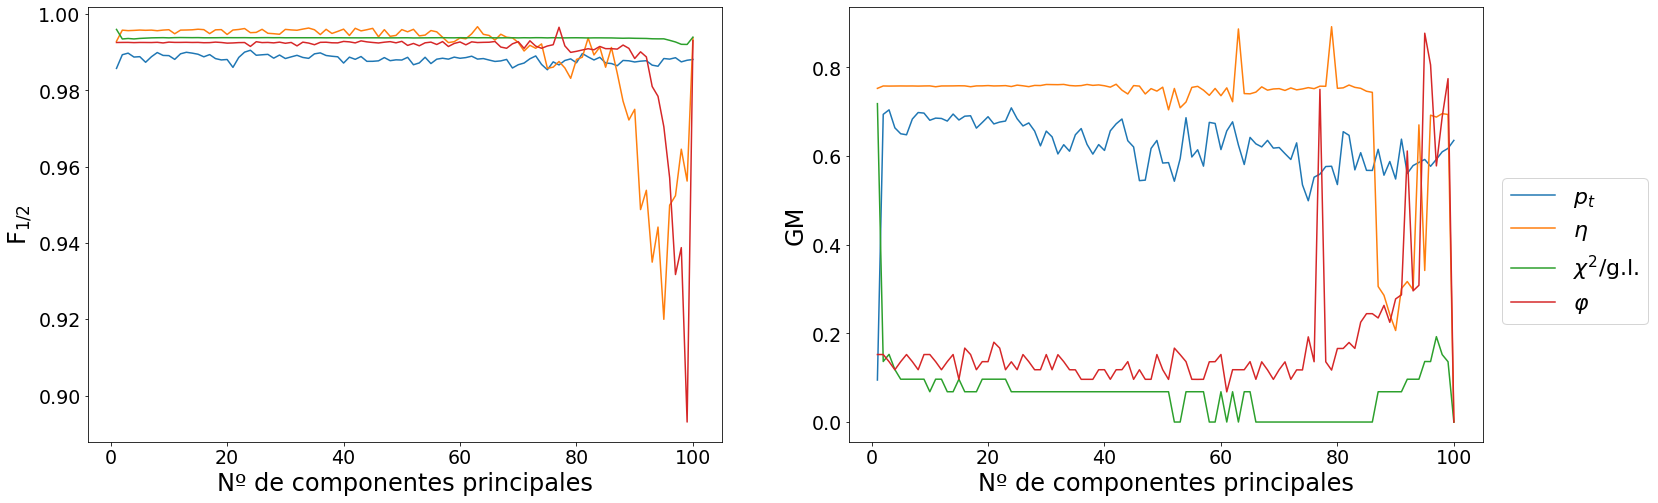

In [77]:
#Representación gráfica de las métricas de evaluación para estimar el número óptimo de componentes principales
fig, axs = plt.subplots(1,2)
ax0, ax1 = axs.flatten()
ax0.plot(F12_pt)
ax0.plot(F12_eta)
ax0.plot(F12_chi2OverDf)
ax0.plot(F12_phi)
ax0.set_xlabel('Nº de componentes principales', fontsize=24)
ax0.set_ylabel(r'F$_{1/2}$', fontsize=24)
ax0.tick_params(axis='both', labelsize=19)
ax1.plot(GM_pt)
ax1.plot(GM_eta)
ax1.plot(GM_chi2OverDf)
ax1.plot(GM_phi)
ax1.set_xlabel('Nº de componentes principales', fontsize=24)
ax1.set_ylabel('GM', fontsize=24)
ax1.tick_params(axis='both', labelsize=19)
fig.set_size_inches(25, 8)
fig.legend(labels=[r'$p_{t}$', r'$\eta$', r'$\chi^2$/g.l.', r'$\varphi$'], loc='right', fontsize=22)
fig.savefig('graficas/NumeroPC.pdf')

# Importancia de cada propiedad física

In [78]:
#Permite obtener la matriz de confusión para todas las eras usando como único criterio la propiedad prop con n componentes principales
lista_tr = [['B','C','D'], ['A','C','D'], ['A','B','D'], ['A','B','C']]
lista_eval = [['A'], ['B'], ['C'], ['D']]
n = 2
prop = 'eta'
TP_tot = 0
FP_tot = 0
FN_tot = 0
TN_tot = 0

for i in range(0,4):
    entrenamiento = lista_tr[i]
    evaluacion = lista_eval[i]
    malos, mse = datos_malos_PC(conjuntos, V, entrenamiento, evaluacion, n, prop)
    TP, FP, FN, TN = resultados_prop(conjuntos,evaluacion,malos,0)
    TP_tot = TP_tot+TP
    FP_tot = FP_tot+FP
    FN_tot = FN_tot+FN
    TN_tot = TN_tot+TN
print('TP:',TP_tot,'  FN:',FN_tot)
print('FP:',FP_tot,'     TN:',TN_tot)

TP: 227679   FN: 773
FP: 834      TN: 598


# Comportamiento de los datos descartados

In [79]:
#Calculamos el ECM para cada bin de todos los datos malos de la era indicada en evaluacion después de entrenar el modelo con las eras de entrenamiento
#Ponemos un ejemplo de un histograma etiquetado malo y su reconstrucción: q = 22 en A, 64 en B, 77 en C, 81 en D
entrenamiento = ['B','C','D']
evaluacion = ['A']
n = [2,1,2,3]

malos2,_ = datos_malos(conjuntos, V, entrenamiento, evaluacion, n)
recon2,_ = evaluation(V['Veta{}'.format(evaluacion[0])], training(conjuntos, V, 'eta', entrenamiento, 2, 0))

datos_eta = V['Veta{}'.format(evaluacion[0])]
recon_eta,_ = evaluation(datos_eta, training(conjuntos, V, 'eta', entrenamiento, 2, 0))

norma_eta = np.max([np.max(datos_eta[malos2], axis = 1), np.max(recon_eta[malos2], axis = 1)], axis = 0)
alturas_eta = np.sum(((datos_eta[malos2]-recon_eta[malos2])/norma_eta[:,None])**2, axis=0)/len(malos2)

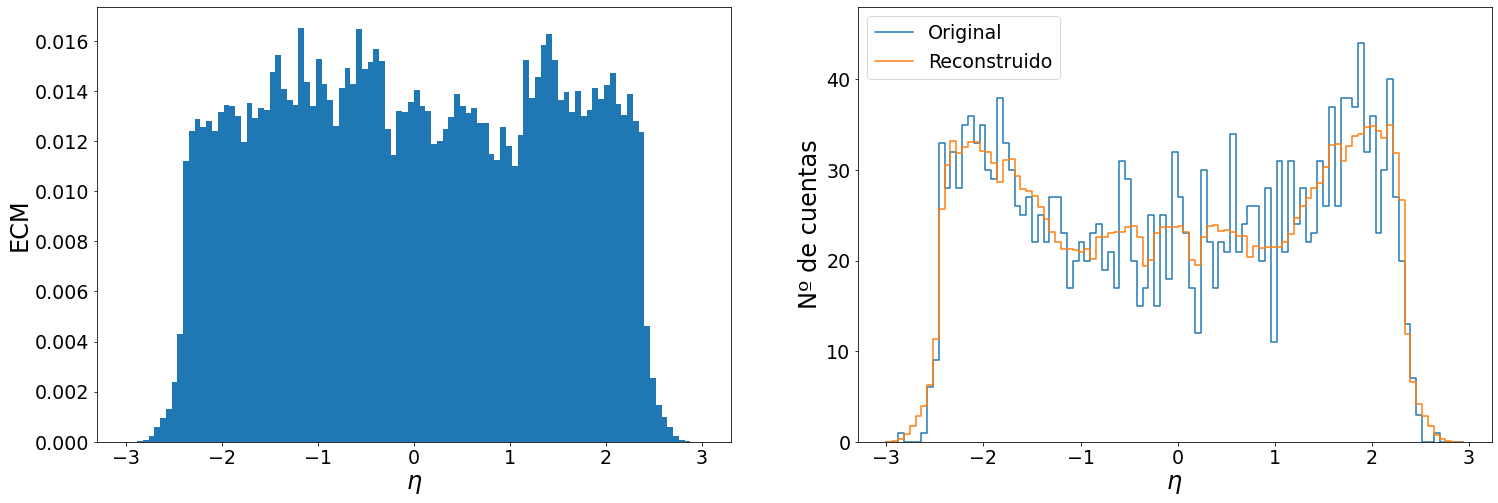

In [80]:
#Representa gráficamente los histogramas asociados a los cálculos anteriores
q = 22
fig, axs = plt.subplots(1,2)
ax0, ax1 = axs.flatten()
ax0.bar(x['x_eta'], alturas_eta, align='edge', width=(x['x_eta'][1]-x['x_eta'][0]))
ax0.set_xlabel(r'$\eta$', fontsize=24)
ax0.set_ylabel('ECM', fontsize=24)
ax0.tick_params(axis='both', labelsize=19)
ax1.step(x['x_eta'], V['Veta{}'.format(evaluacion[0])][malos2[q]], label='Original')
ax1.step(x['x_eta'], recon2[malos2[q]], label='Reconstruido')
ax1.set_xlabel(r'$\eta$', fontsize=24)
ax1.set_ylabel('Nº de cuentas', fontsize=24)
ax1.tick_params(axis='both', labelsize=19)
ax1.legend(fontsize=19)
ax1.set_ylim((0,48))
fig.set_size_inches(25, 8)
fig.savefig('graficas/GeometriaA.pdf', dpi=100)

# Estudio de la influencia del cambio entre mediana y media

In [81]:
#Obtiene las matrices de confusión a lo largo de las 4 eras usando la media y la mediana para compararlas
lista_tr = [['B','C','D'], ['A','C','D'], ['A','B','D'], ['A','B','C']]
lista_eval = [['A'], ['B'], ['C'], ['D']]
n = [2,1,2,3]
TP_tot = 0
FP_tot = 0
FN_tot = 0
TN_tot = 0

for i in range(0,4):
    entrenamiento = lista_tr[i]
    evaluacion = lista_eval[i]
    malos, mse = datos_malos(conjuntos, V, entrenamiento, evaluacion, n)
    TP, FP, FN, TN = resultados_prop(conjuntos,evaluacion,malos,0)
    TP_tot = TP_tot+TP
    FP_tot = FP_tot+FP
    FN_tot = FN_tot+FN
    TN_tot = TN_tot+TN
print('MATRIZ DE CONFUSIÓN MEDIANA')
print('TP:',TP_tot,'  FN:',FN_tot)
print('FP:',FP_tot,'     TN:',TN_tot)

TP_tot = 0
FP_tot = 0
FN_tot = 0
TN_tot = 0

for i in range(0,4):
    entrenamiento = lista_tr[i]
    evaluacion = lista_eval[i]
    malos, mse = datos_malos_mean(conjuntos, V, entrenamiento, evaluacion, n)
    TP, FP, FN, TN = resultados_prop(conjuntos,evaluacion,malos,0)
    TP_tot = TP_tot+TP
    FP_tot = FP_tot+FP
    FN_tot = FN_tot+FN
    TN_tot = TN_tot+TN
print('MATRIZ DE CONFUSIÓN MEDIA')
print('TP:',TP_tot,'  FN:',FN_tot)
print('FP:',FP_tot,'     TN:',TN_tot)

MATRIZ DE CONFUSIÓN MEDIANA
TP: 220200   FN: 8252
FP: 763      TN: 669
MATRIZ DE CONFUSIÓN MEDIA
TP: 207982   FN: 20470
FP: 1005      TN: 427


# Generación de gráficas para el anexo I

In [82]:
#Se generan determina el mse y los datos descartados para la propiedad prop
entrenamiento = ['B','C','D']
evaluacion = ['A']
n = 3
prop = 'pt'

malos, mse = datos_malos_PC(conjuntos, V, entrenamiento, evaluacion, n, prop)

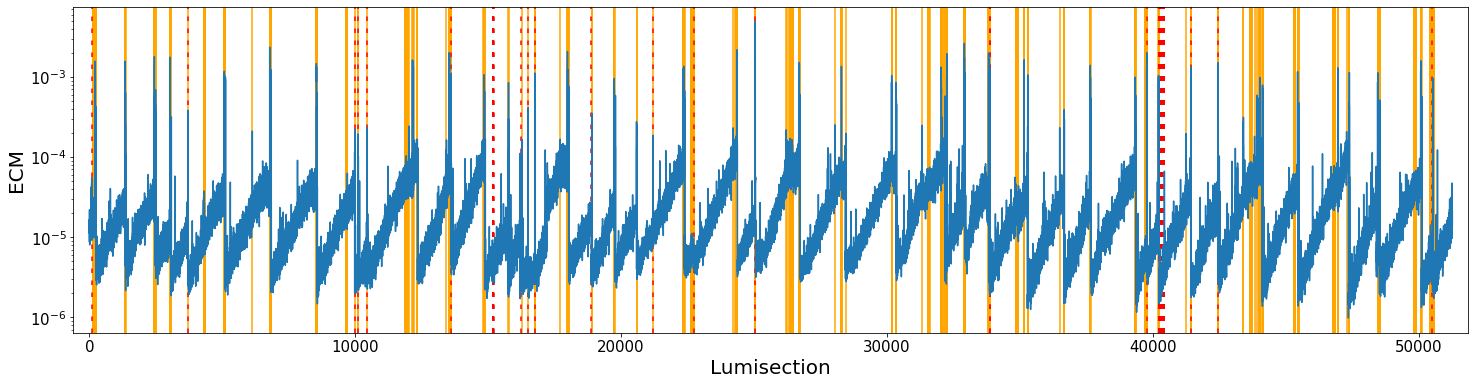

In [83]:
#Aquí el mse es el correspondiente a pt. Son los descartes del modelo completo.
plt.figure(figsize=(25,6))
falsos = conjuntos['pt{}'.format(evaluacion[0])][conjuntos['pt{}'.format(evaluacion[0])]['labels']==False]['new_lumi']
for j in malos:
    plt.axvline(x = j, color='orange', zorder=1)
for coord in falsos:
    plt.axvline(x = coord, color='red', linestyle=(0,(3,5)))
plt.plot(mse)
plt.yscale('log') 
plt.xlabel('Lumisection', fontsize = 20)
plt.ylabel('ECM', fontsize = 20)
plt.tick_params('x', labelsize = 15)
plt.tick_params('y', labelsize = 15)
plt.xlim((-600,len(mse)+600))
plt.savefig('graficas/ptA.pdf', dpi=100)